# Stock Market Prediction With ML


## Download The Data For S&P 500

In [24]:
pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import os

In [3]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")
    sp500.index = pd.to_datetime(sp500.index)

In [4]:
sp500.head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.66,17.66,17.66,17.66,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.76,17.76,17.76,17.76,0,0.0,0.0


## Clean And Visualize The Stock Market Data

In [5]:
import numpy as np                          
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sp500.drop(columns=["Dividends" ,"Stock Splits"], axis=1, inplace=True)

sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)  #1 - price goes up , 0 - price goes down


In [7]:
sp500 = sp500.loc["1990-01-01":].copy()

In [8]:
sp500.shape

(8354, 7)

In [9]:
sp500.head(3)

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0


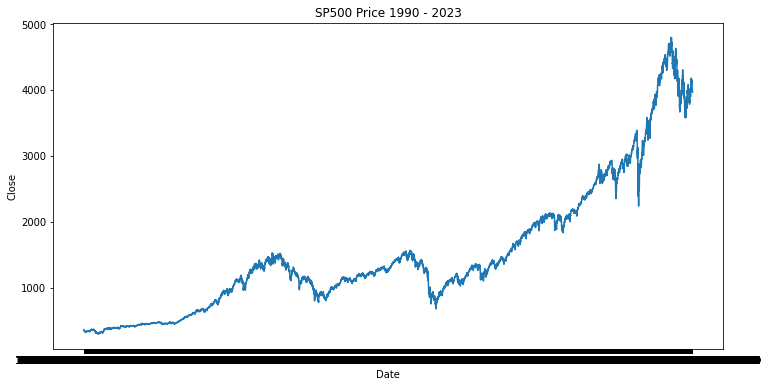

In [10]:
plt.figure(figsize=(12,6))
sns.lineplot(x="Date", y="Close", data=sp500)
plt.title("SP500 Price 1990 - 2023")
plt.show()


## Training Our Machine Learning Model

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [12]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.35714285714285715

The model have low accuracy vs the test set

<AxesSubplot:xlabel='Date'>

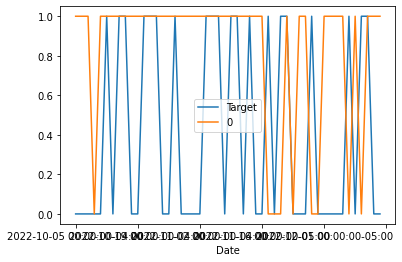

In [13]:
combined = pd.concat([test["Target"], preds], axis=1)
combined[:50].plot() # predict 1 too often

## Building a Backtesting System

### Prediction function that returns new df with target and prediction

In [14]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

### Backtest function

In [15]:
def backtest(data, model, predictors, start=2500, step=250):  # you can change the step
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

### New model performance

In [25]:
predictions = backtest(sp500, model, predictors)
predictions["Predictions"].value_counts()

0.0    3897
1.0     957
Name: Predictions, dtype: int64

In [17]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5275173257236038

In [18]:
predictions["Target"].value_counts() / predictions.shape[0] # % of the market goes up vs goes down

1    0.533652
0    0.466348
Name: Target, dtype: float64

## Let`s Build a Horizon Function for Price Trends And Better Performance

In [19]:
horizons = [2,5,60,250,1000] # you can change trend days
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

### Add the price trends ( 2,5,60,250,1000 days) into the train data

In [20]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])
sp500.head(3)

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0


## Let`s Make a New Model

In [21]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

In [22]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.58] = 1
    preds[preds <.58] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

### New model performance

In [23]:
predictions = backtest(sp500, model, new_predictors)
predictions["Predictions"].value_counts()

0.0    3579
1.0    1275
Name: Predictions, dtype: int64

In [24]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5701960784313725

Combine the model with technical analysis and proper risk management for better success